# Analyis for optoTAF15-IDR with transfected MS2-reporter

## Summary

### Dataset description
- Full dataset containing 22 ROIs from 5 cells. These include the following 
phenotypes,
    1. ROI with both droplet and transcription focus,
    2. ROI with only droplet but no transcription focus,
    3. ROI with only transcription focus but no droplet.

### Brief conclusion
- Correlation between signals from optoTAF15IDR and from MS2 stem-loop/MCP 
transcription reporter appears to exist based on preliminary analysis. The 
following results can be found below
    1. Pairwise correlation coefficient (Pearson's $r$ between first-order 
       derivatives of droplet signal and of transcription signal) is 
       different among phenotype 1 ($r \sim 0.4$) and others ($r \sim 0$).
       See the boxplots and statistic tests under section 2.5.
    2. Aggregated data from ROIs of phenotype 1 show the trend of increasing
       droplet and transcription signals as time evolves. (Time is rescaled 
       to $[0,1]$ corresponding to the beginning and end of data collection 
       for each ROI.) See the boxplots and statistic tests under section 2.4.
    

In [1]:
from pathlib import Path
import pandas as pd

In [2]:
# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

In [3]:
# Visualization packages
import altair as alt
from altair_saver import save as altsave

In [4]:
from src import helper

In [5]:
# ==========
# Load data and clean up
# ==========
root_dir = Path(".").joinpath("..")
data_dir = root_dir.joinpath("data")
report_dir = helper.mkdir_if_not_exist( root_dir.joinpath("report","trajectory") )
    

fname = "trajectory.xlsx"
fpath = data_dir.joinpath(fname)

# Load as a pd.dataframe
data = pd.read_excel(fpath, header=[0,1,2], na_values="--")
# data.head()

In [6]:
# Clean df and reorganize
# Remove empty columns
df = data.dropna(axis="columns", how="all")
# Remove trailing NaN's
df = df.iloc[:df.last_valid_index()]
# Remove timepoints with NaN values
df = df.dropna(axis="rows", how="all")

# Extract info about ROI phenotype
phenotype = (df.columns.droplevel(-1)
    .to_frame(name=["hasDroplet","hasMCP"])
    .iloc[1::4,:].reset_index()
    .reset_index().assign(id_ = lambda x: x.index + 1)
    .loc[:,["id_","hasDroplet","hasMCP"]]
    .assign(phenotype= lambda x: 4 - x.hasDroplet*2 - x.hasMCP*1) # 1: both; 2: drop-only; 3: mcp-only
    .assign(hasBoth= lambda x: x.hasDroplet & x.hasMCP)
)


# Rename column names
# Throwout phenotype info and promote time to index
df = df.droplevel([1,2], axis="columns")
df = df.set_index("time")
df = df.rename_axis(index="time")
# Build index
try:
    n_obj = df.shape[1]//4
    assert n_obj*4 == df.shape[1]
except AssertionError:
    print("Original data format isn't as expected.")
    
names=['id_','property','channel']
idx = pd.MultiIndex.from_product(
    [range(1,n_obj+1), ['mean', 'error'], ['mcp','droplet']],
    names=names)

df.columns = idx

# Tidy up the dataset
tidy0 = (df.transpose()
          .reset_index()
          .melt(id_vars=names, value_name="value")
          .set_index(names+["time"])
          .dropna(axis="rows", how="any")
          .unstack(level="property")
          .droplevel(level=0, axis="columns")
          .reorder_levels(["id_","time","channel"])
          .sort_values(by=["id_","time","channel"])
       )
tidy0.columns = tidy0.columns.rename(None)
tidy0 = tidy0.reset_index().merge(phenotype, on="id_")
# tidy0.head()

In [7]:
# Creating some more useful dataframes
def pd_pivot_wider(df, var, id_vars, sep='_', prepend=True):
    """Spread dataframe by increasing col no. and decreasing row no."""
        
    
    var = [var] if not isinstance(var,list) else var
    id_vars = [id_vars] if not isinstance(id_vars,list) else id_vars
        
    df = (df.set_index(id_vars+var)
            .unstack(level=var[0]))
    
    if prepend:
        col_names = (df.columns.get_level_values(1).astype(str)
                     + sep
                     + df.columns.get_level_values(0).astype(str))
    else:
        col_names = (df.columns.get_level_values(0).astype(str)
                     + sep
                     + df.columns.get_level_values(1).astype(str))
    
    df = df.droplevel(-1, axis='columns')
    df.columns = col_names
    df = df.reset_index()
    
    return df

In [8]:
# Another tidy dataset
tidy = tidy0.pipe(pd_pivot_wider,
                  var='channel',
                  id_vars=["id_","time","hasDroplet","hasMCP","phenotype","hasBoth"])
# tidy.head()

## Exploratory data analysis

### 1) Plotting time series for each ROI

In [9]:
def plot_profiles(data):

    base = alt.Chart(data).transform_calculate(
        mm = "datum.mean / 1000",
        ee = "datum.error / 1000",
        min_ = "datum.mm - datum.ee",
        max_ = "datum.mm + datum.ee"
    )

    profile = (
        base.mark_line(point=False).encode(
            x='time:Q',
            y=alt.Y('mm:Q', title=None),
            color=alt.Color('channel:N', legend=None),
        ).properties(
            width=70, height=30,
        )
    )

    errorbars = base.mark_errorbar().encode(
        x="time:Q",
        y="min_:Q",
        y2="max_:Q",
        color=alt.Color('channel:N', legend=None)
    )

    profile_err = alt.layer(errorbars, profile).facet(column='id_:O', row="channel:N")
    
    return profile_err


# Produce one chart for each phenotype
profile_plots = [plot_profiles(tidy0.query("phenotype == @ptype"))
                 .resolve_scale(y="independent")
                 for ptype in [1,2,3]]

profile_plots_fig = (
    alt.vconcat(*profile_plots)
    .configure_axis(grid=False)
    .configure_facet(spacing=5)
    .resolve_scale(x="shared")
)

profile_plots_fig

alt.VConcatChart(...)

### 2) Correlation between two channels

#### 2.1) Plot two channels against each other for each ROI

In [10]:
# Using Altair
def plot_scatter_reg(data, x='droplet_mean', y='mcp_mean'):

    base = alt.Chart().encode(
        x=alt.X(x, scale=alt.Scale(zero=False)),
        y=alt.Y(y, scale=alt.Scale(zero=False))
    ).properties(
        width=80, height=80
    )

    points = base.mark_point().encode(
        color=alt.Color('phenotype:N'),
        opacity=alt.value(0.5)
    )
    fit = base.transform_regression(x,y).mark_line(color='grey')

    overlay = (
        alt.layer(points, fit, data=data)
        .facet(facet='id_', columns=5)
        .resolve_scale(x="independent", y="independent")
    )
    
    return overlay

plot_scatter_reg(tidy).configure_axis(grid=False).configure_facet(spacing=0)

alt.FacetChart(...)

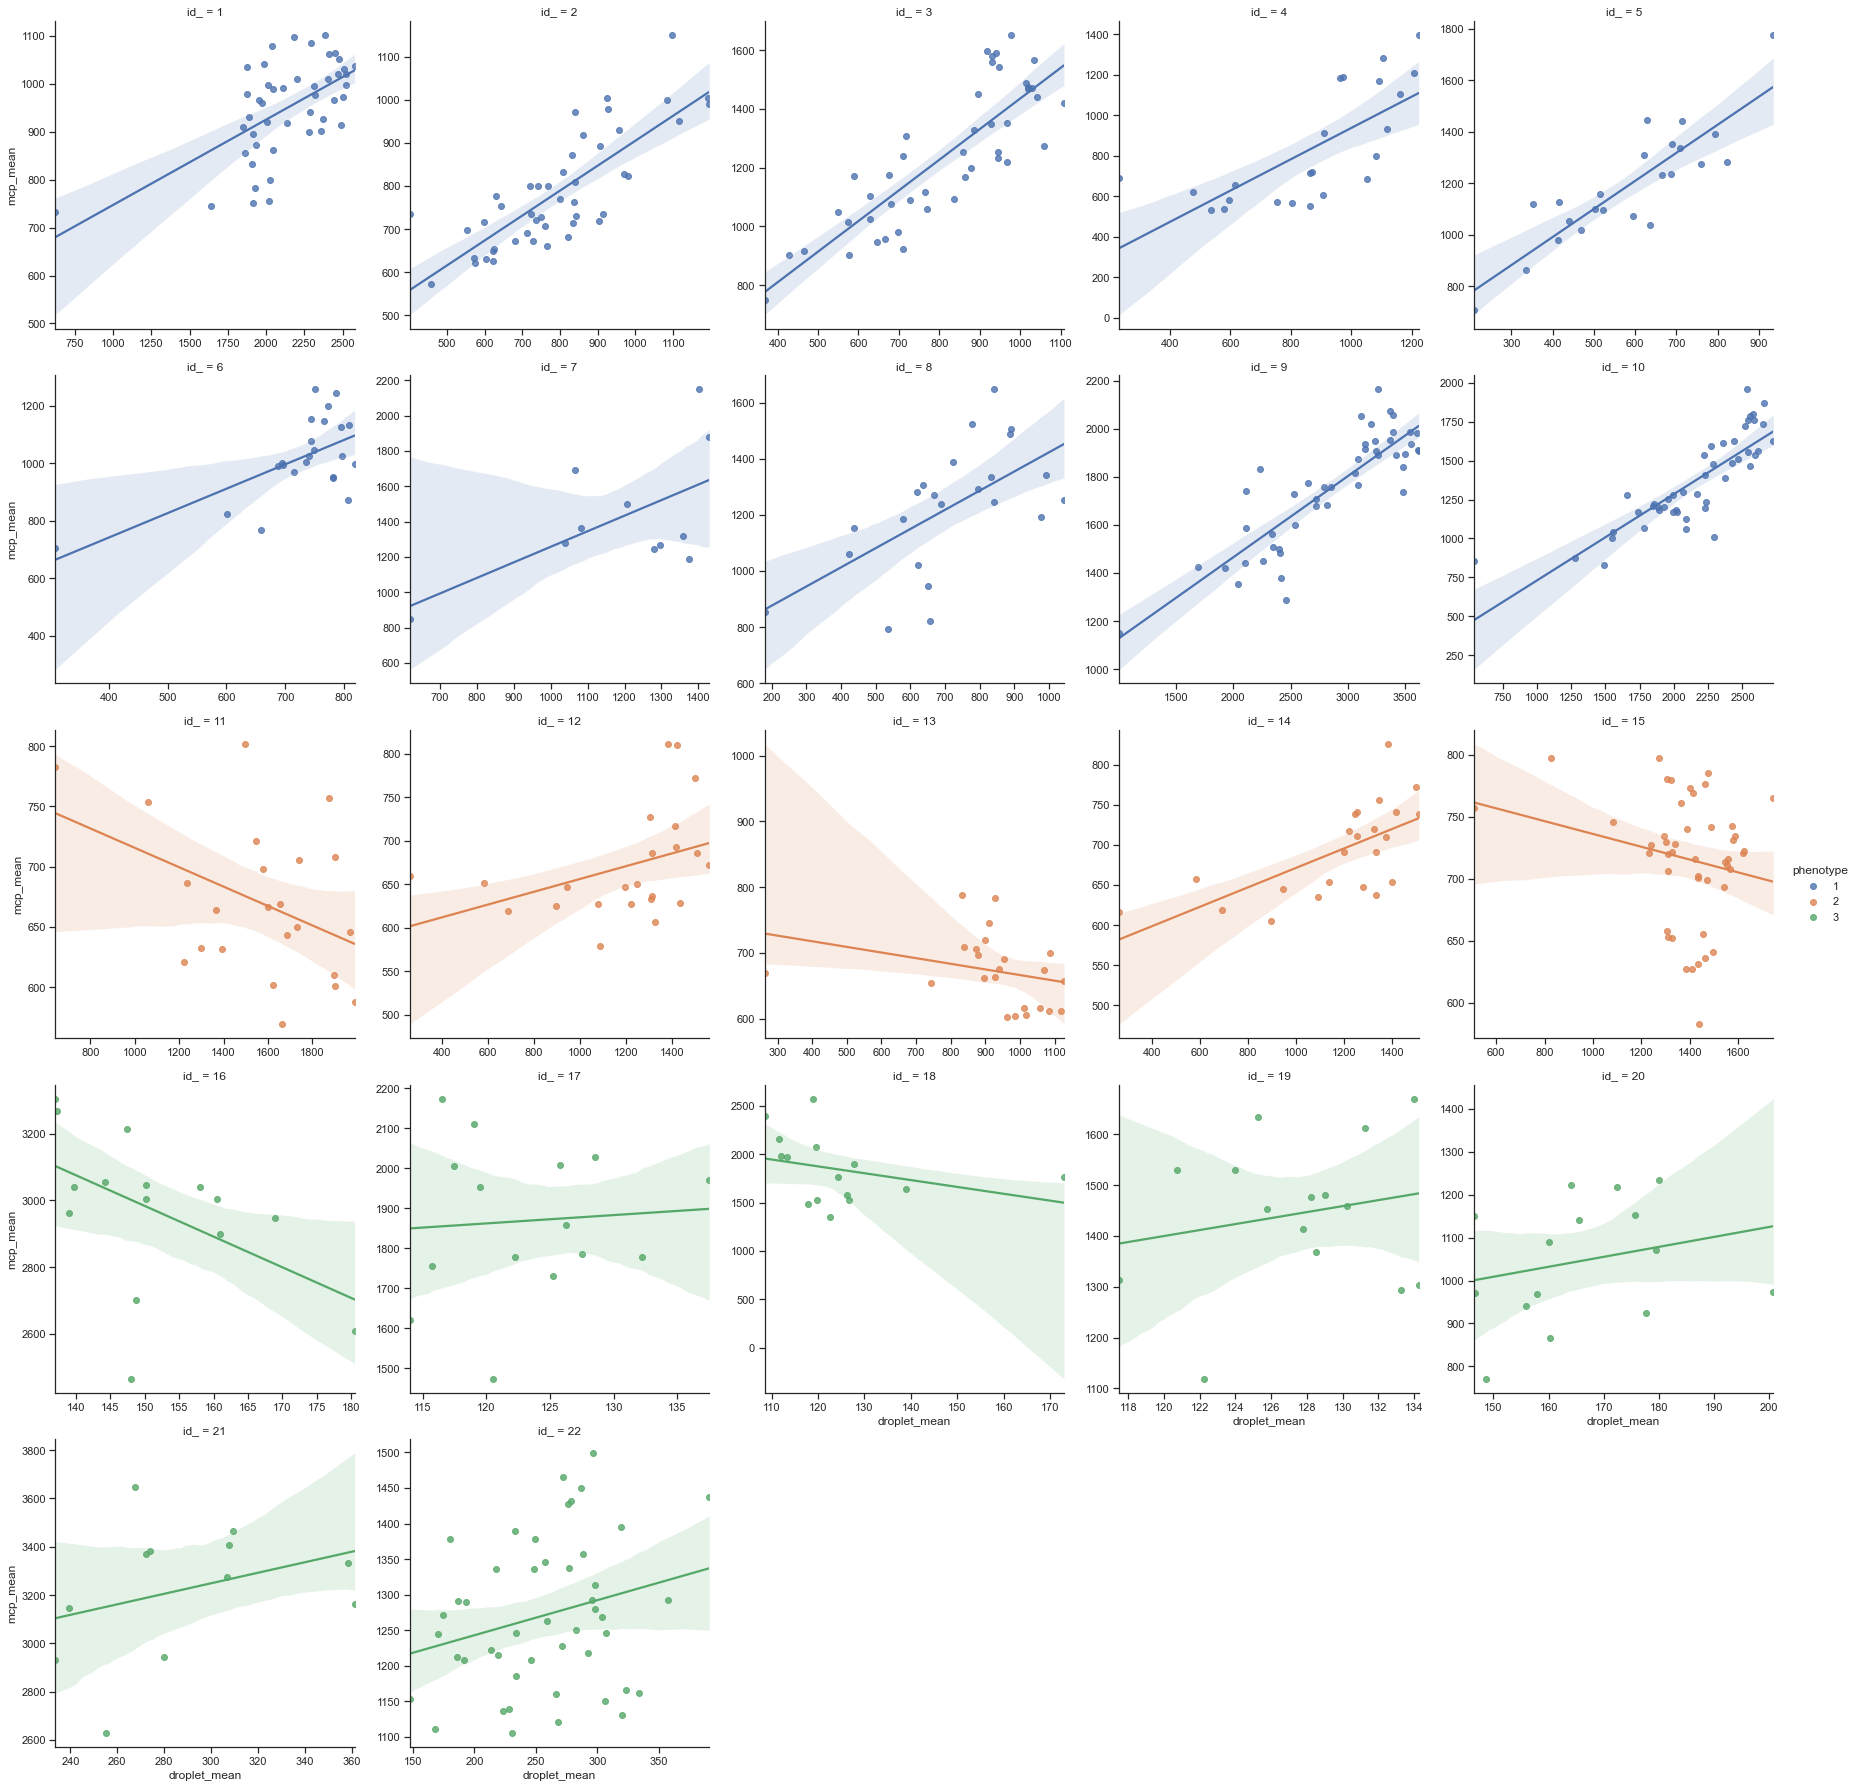

In [11]:
# Plot with seaborn
fig = sns.lmplot(
    data=tidy,
    x="droplet_mean", y="mcp_mean",
    col="id_", col_wrap=5, hue="phenotype",
    sharex=False, sharey=False
)

#### 2.2) Calculate and summarize corr coeff.

In [12]:
# Calculate Spearman corr coeff between two channels
def calc_pairwise_corr(df, col1, col2,
                       by, method, merge=False):
    
    pairwise_corr = (df
        .groupby(by)[[col1,col2]].corr(method=method)
        .droplevel(-1, axis="index")
        .iloc[0::2][[col2]]
        .rename(columns={col2: method})
        .reset_index()
    )
    
    if merge:
        pairwise_corr = pairwise_corr.merge(df, on="id_")
    
    return pairwise_corr


# Test out the above function `calc_pairwise_corr()`
# calc_pairwise_corr(tidy,
#    "mcp_mean", "droplet_mean",
#     by="id_", method="pearson", merge=True
# ).head()

In [13]:
def plot_pairwise_corr(data, var_names, cat_names=["hasBoth", "phenotype"],
                       by="id_", method="pearson"):
    """Plot pairwise corr for each ROI and group by phenotype.
    
    
    Parameters
    ----------
    data : pandas.DataFrame
    var_names : list of str
        Col names for variables used to compute their corr coeff.
    cat_names : list of str
        Col names for categorical variables used as the x-axis. Each item 
        generates one figure.
    by : str
        Col name for variable used for grouping. 
    method : str
        Method for calculating corr coeff. Provided by pandas.DataFrame and 
        can be 'pearson', 'kendall' or 'spearman'.
        
    
    Returns
    -------
    fig : matplotlib.Figure
        Boxplots plotted according to groupings specified in `cat_names`.
    dfout : pandas.DataFrame
        Dataframe contains group var, categorical vars, and corr coeff.
        
        
    """
    
    # Calculate correlation coefficient
    # All original columns are preserved
    df = calc_pairwise_corr(
        data,
        col1=var_names[0], col2=var_names[1],
        by=by, method=method, merge=True
    )
    
    # Prepare necessary data for plotting
    # Manually grouping followed by dropping duplicates
    df2 = df[cat_names+[method]].drop_duplicates()
    
    
    # Loop through each categorical var
    fig, ax = plt.subplots(ncols=len(cat_names))
    for x,a in zip(cat_names,ax):
        # Box-and-whisker plot
        sns.boxplot(ax=a, data=df2,
                    x=x, y=method,
                    width=0.5, boxprops={"color": ".8"},
                    showmeans=True, meanline=True)
        # Put individual data points
        sns.swarmplot(ax=a, data=df2,
                      x=x, y=method,
                      size=8, color="white", alpha=0.5,
                      edgecolor=".5", linewidth=1)
        # Put y-errorbars
        x_ = range(0,len(df2[x].unique()))
        y_ = df2.groupby(x)[method].mean()
        ye_ = df2.groupby(x)[method].sem()
        a.errorbar(x=x_, y=y_, yerr=ye_,
                   fmt='none', ecolor='green')
        a.set_ylabel(None)
        a.set_title(method)

    
    # Prepare dataframe to split out
    dfout = (df[["id_"]+cat_names+[method]]
             .drop_duplicates()
             .reset_index().drop("index", axis="columns")
            )
    
    return fig, dfout

- Boxplot to summarize distribution of correlation coefficients groupped by 
phenotype of ROIs. Dots represent ndividual correlation coefficients; green 
dotted lines indicate mean; and green vertical lines show 
$\pm \mathrm{s.d.}$.

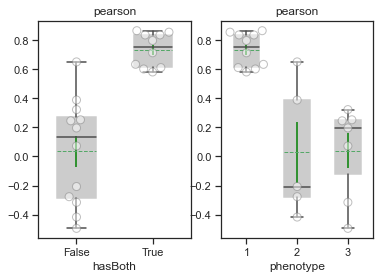

In [14]:
# Vis distribution of corr coeff for each phenotype
pairwise_corr_fig, pwc = plot_pairwise_corr(
    tidy, ["droplet_mean","mcp_mean"],
    method="pearson"
)

pairwise_corr_fig.savefig(
    report_dir.joinpath("pixelValueCorr_boxplot.svg"),
    dpi=300)

In [15]:
pwc.to_csv(report_dir.joinpath("pixelValueCorr.csv"))
pwc

,id_,hasBoth,phenotype,pearson
0,1,True,1,0.601682
1,2,True,1,0.797575
2,3,True,1,0.835752
3,4,True,1,0.713268
4,5,True,1,0.865087
5,6,True,1,0.633653
6,7,True,1,0.581254
7,8,True,1,0.611292
8,9,True,1,0.854940
9,10,True,1,0.836189


- Perform Welch t-test (two-sample t-test with unequal sample size and 
unequal variance).

In [16]:
from statsmodels.stats.weightstats import ttest_ind

df = (pwc
    .loc[:,["id_","phenotype","hasBoth","pearson"]]
    .drop_duplicates()
)

$H_0: r_\mathrm{ptype1} = r_\mathrm{ptype2}$; $H_1: r_\mathrm{ptype1} > r_\mathrm{ptype2}$

In [17]:
# phenotype
# H_0: r_ptype1 = r_ptype2; H_1: r_ptype1 > r_ptype2
x = df[df["phenotype"]==1]["pearson"]
y = df[df["phenotype"]==2]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 0.013092776118772362.


$H_0: r_\mathrm{ptype1} = r_\mathrm{ptype3}$; $H_1: r_\mathrm{ptype1} > r_\mathrm{ptype3}$

In [18]:
# H_0: r_ptype1 = r_ptype3; H_1: r_ptype1 > r_ptype3
x = df[df["phenotype"]==1]["pearson"]
y = df[df["phenotype"]==3]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 0.0004119419967622467.


$H_0: r_\mathrm{hasBoth} = r_\mathrm{not-hasBoth}$; $H_1: r_\mathrm{hasBoth} > r_\mathrm{not-hasBoth}$

In [19]:
# hasBoth
# H_0: r_ptype1 = r_ptype2; H_1: r_ptype1 > r_ptype2
x = df[df["hasBoth"]==True]["pearson"]
y = df[df["hasBoth"]==False]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 1.2087465384140589e-05.


#### 2.3) Plot rescaled data

- Rescale each channel to its zscore within an ROI

In [20]:
# Prepare df with rescaled data
from sklearn import preprocessing
import numpy as np

# Maybe can chain this into the pipe...?
def ztransform(df, col):
    """Offset with mean and rescale with sd, then assign as a new col."""
    data = df[[col+'_mean']]
    scaler_mean = preprocessing.StandardScaler().fit(data)
    
    df[col+'_mean_z'] = scaler_mean.transform(df[[col+'_mean']])
    df[col+'_error_z'] = df[[col+'_error']] / np.sqrt(scaler_mean.var_)
    
    return df



df = (tidy
    .groupby("id_").apply(ztransform, col="mcp")
    .groupby("id_").apply(ztransform, col="droplet")
)

# df.head()

- Plot aggregated data for each phenotype

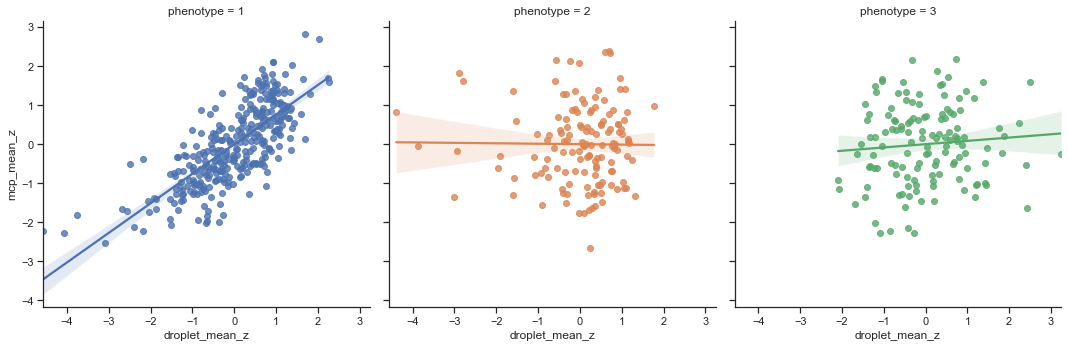

In [21]:
fig = sns.lmplot(
    data=df,
    x="droplet_mean_z", y="mcp_mean_z",
    col="phenotype", hue="phenotype"
)

- Plot for individual ROI

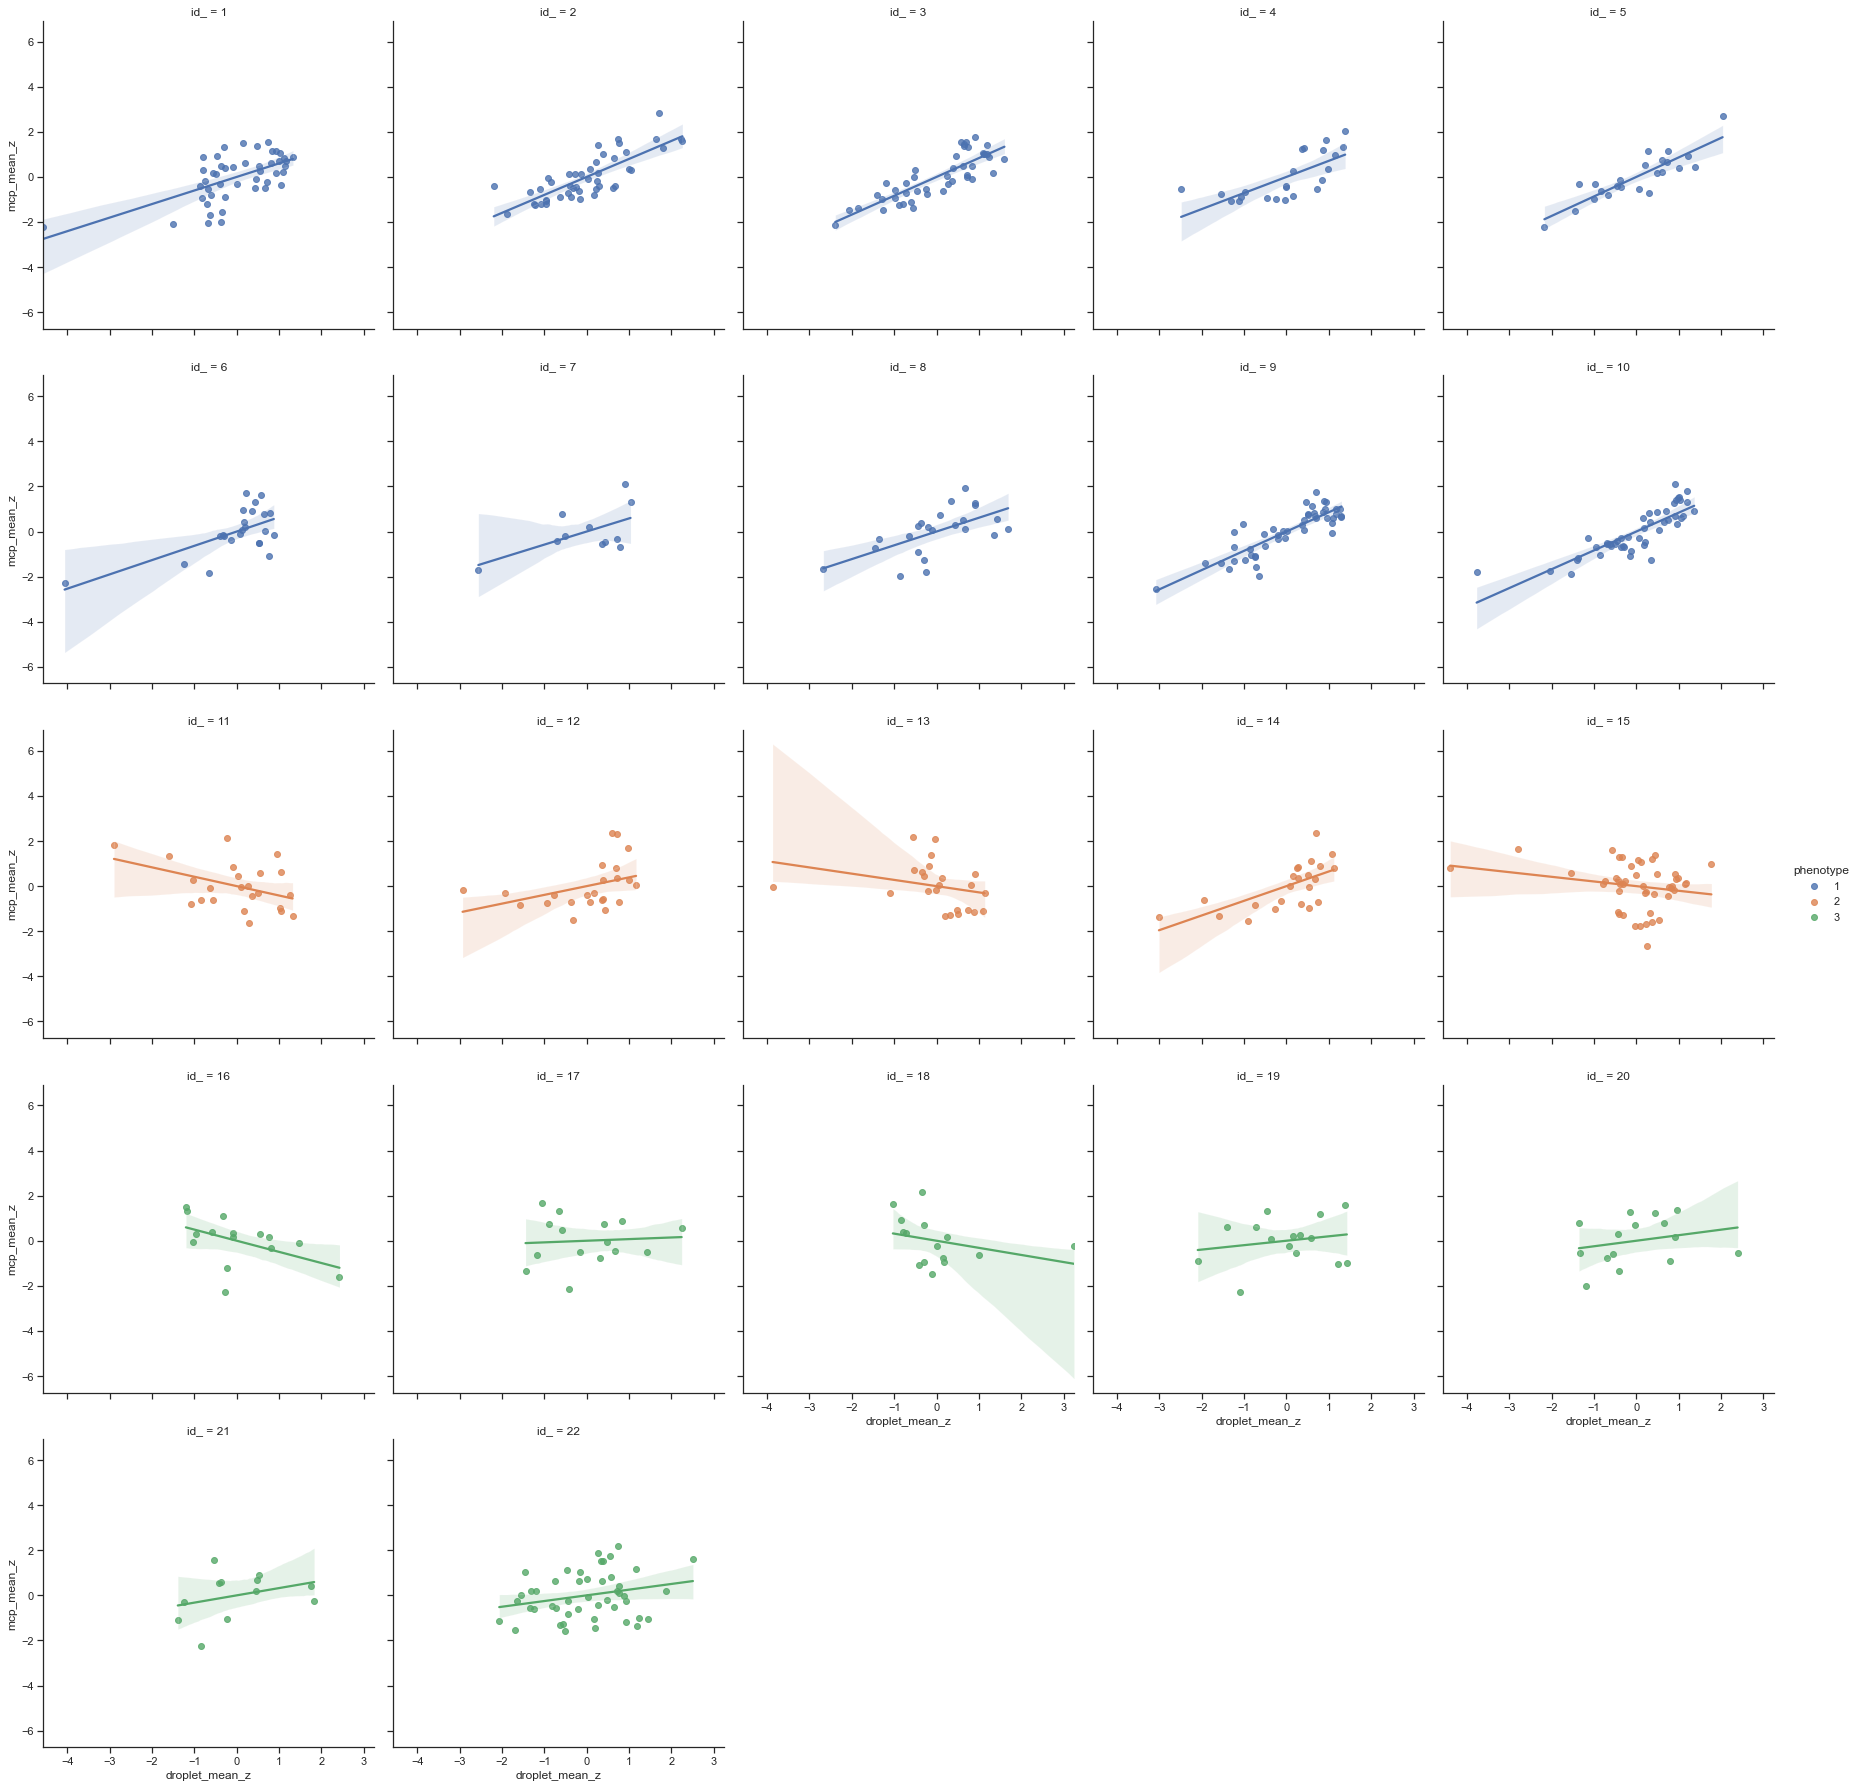

In [22]:
fig = sns.lmplot(
    data=df,
    x="droplet_mean_z", y="mcp_mean_z",
    col="id_", col_wrap=5, hue="phenotype"
)

#### 2.4) Plot rescaled data including time information

- Rescale time to range [0,1] within each ROI

In [23]:
# Rescale time by max to 0-to-1
def rescale_time(df, col="time"):
    df["rel_time"] = df["time"] / df["time"].max()
    
    return df
    
df2 = df.groupby("id_").apply(rescale_time)
# df2.head()

In [24]:
def plot_scatter_time(data, x='droplet_mean_z', y='mcp_mean_z',
                      errorbar=True, showtime=True, asize=(100,100)):
    """Return alt.LayerChart for scatter plot that can be further faceted.
    
    Parameters
    ----------
    data : pandas.DataFrame
    x, y : str
        Name of col used as x (or y) in `data`.
    errorbar : bool
        Show x- and y-errorbars of each point. Not really supported now...
    showtime : bool
        Show time information encoded by color.
    asize: tuple of number, len(asize)=2
        Size (dimention) of each individual axes
        
    Return
    ------
    alt.LayerChart
        Layered chart that can be further faceted according to viz need.
    
    """
    

    # Calculate min/max for error bars
    base = alt.Chart().transform_calculate(
        xmin='datum.droplet_mean_z - datum.droplet_error_z',
        xmax='datum.droplet_mean_z + datum.droplet_error_z',
        ymin='datum.mcp_mean_z - datum.mcp_error_z',
        ymax='datum.mcp_mean_z + datum.mcp_error_z'
    ).encode(
        x=alt.X(x),
        y=alt.Y(y)
    ).properties(
        width=asize[0],
        height=asize[1]
    )
    
    # points
    points = base.mark_point(filled=True).encode(
        opacity=alt.value(0.5),
        size=alt.value(35))
    if showtime:
        points = points.encode(
            color=alt.Color('rel_time:Q',
                            scale=alt.Scale(scheme='viridis')))
    
    # line for linear fit
    fit = base.transform_regression(x,y).mark_line(color='black')
    
    # errorbars
    if errorbar:
        errorbars = base.mark_errorbar().encode(
            opacity=alt.value(0.3))
        if showtime:
            errorbars = errorbars.encode(
                color=alt.Color('rel_time:Q',
                    scale=alt.Scale(scheme='viridis'),
                    legend=None))

        errorbars_y = errorbars.mark_errorbar().encode(
            y=alt.Y('ymax:Q', title="MCP (z-score)"),
            y2='ymin:Q')

        errorbars_x = errorbars.mark_errorbar().encode(
            x=alt.X('xmin:Q', title="Droplet (z-score)"),
            x2='xmax:Q')
    

    # Facet is not done yet, and can be done outside of this function 
    # according to viz need.
    if errorbar:
        overlay = (alt.layer(
            errorbars_y, errorbars_x, points, fit,
            data=data))
    else:
        overlay = (alt.layer(
            points, fit,
            data=data))
    overlay = overlay.resolve_scale(x="shared", y="shared")
    
    return overlay

- Color coded relative time shown for each ROI

In [25]:
scaled_scatter_byID = (plot_scatter_time(df2)
    .facet(facet="id_:N", columns=5)
    .configure_axis(grid=False)
)
scaled_scatter_byID

alt.FacetChart(...)

- Aggregate ROIs for each phenotype

In [26]:
scaled_scatter_byPhenotype = (plot_scatter_time(df2, asize=(150,150))
    .facet(facet="phenotype:N", columns=5)
    .configure_axis(grid=False)
)

altsave(scaled_scatter_byPhenotype,
    str(report_dir.joinpath("scatterZscoreWithTime.svg")))

altsave(scaled_scatter_byPhenotype,
    str(report_dir.joinpath("scatterZscoreWithTime.vl.json")))


scaled_scatter_byPhenotype

WARN Ignoring an invalid transform: {"on":"droplet_mean_z","regression":"mcp_mean_z"}.


alt.FacetChart(...)

In [27]:
df2.to_csv(report_dir.joinpath("output.csv"))

In [28]:
scaled_scatter_byHasBoth = (plot_scatter_time(df2, asize=(150,150))
    .facet(facet="hasBoth:N", columns=5)
    .configure_axis(grid=False)
)
scaled_scatter_byHasBoth

alt.FacetChart(...)

#### 2.5) Correlation on first-order diff

In [29]:
def diff_(df, var_names, periods=1):
        
    if not isinstance(var_names, list):
        var_names = [var_names]
            
    for v in var_names:
        df["diff_"+v] = df[v].diff(periods=periods)
    
    return df


diff_on = ["droplet_mean", "droplet_mean_z",
           "mcp_mean", "mcp_mean_z"]

df3 = (df2
    .groupby("id_").apply(diff_, ["time"] + diff_on)
    .dropna(axis="rows", how="any")
)
# calculate actual 1st-order derivative
for c in diff_on:
    df3[c] = df3[c]/df3["diff_time"]
# df3.head()

- Plot differentiated time series ($\hat{y}_t = \frac{y_{t} - y_{t-1}}{T_t - T_{t-1}}, t = 2,3,...$) 
of two channels for each ROI.

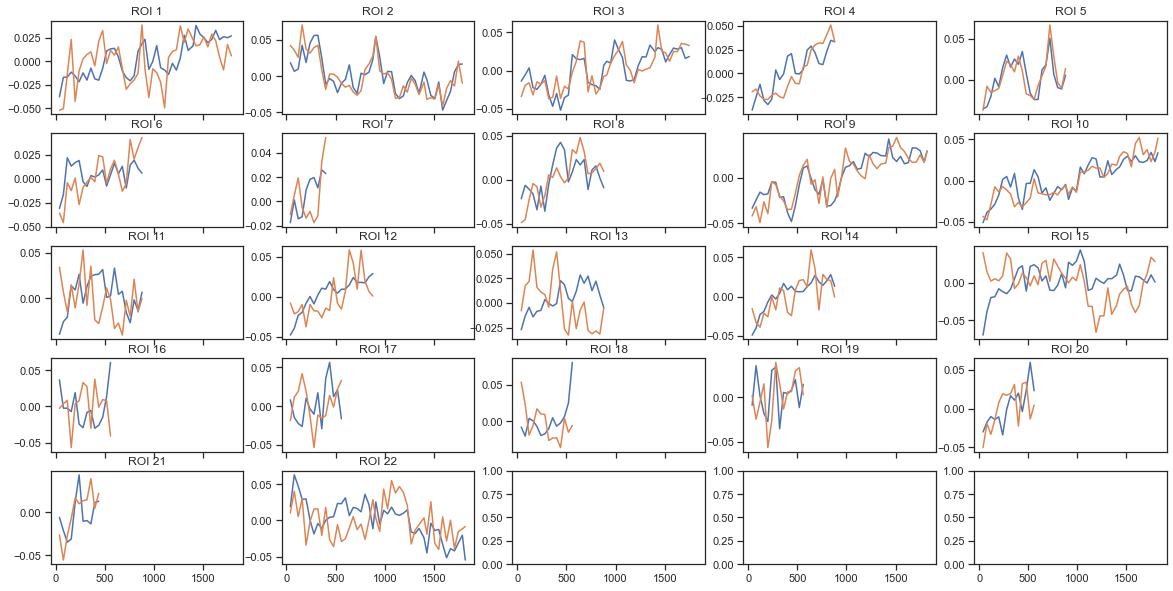

In [30]:
def plot_diff(df, var_names):
    """Plot differentiated time series."""
    
    data = (df.loc[:,["time","id_"]+var_names]
        .set_index(["time","id_"]).unstack("id_")
    )
    
    
    iROI = df["id_"].sort_values().unique()
    n = len(iROI)
    wrap = 5
    fig, ax = plt.subplots(ncols=min(n,wrap),
                           nrows=1+(n-1)//wrap,
                           figsize=(20,10),
                           sharex=True)
    
    for i,a in zip(iROI,ax.flat):
        d = data.transpose().query('id_ == @i').transpose()
        a.plot(d[var_names])
        a.set_title(f"ROI {i}")
        
    fig.set
        
    return fig
        
diff_profile = plot_diff(df3, ["droplet_mean_z","mcp_mean_z"])

- Plot pairs of two channels from rescaled and differentiated data. (No time 
information shown as it is not meaningful here.)

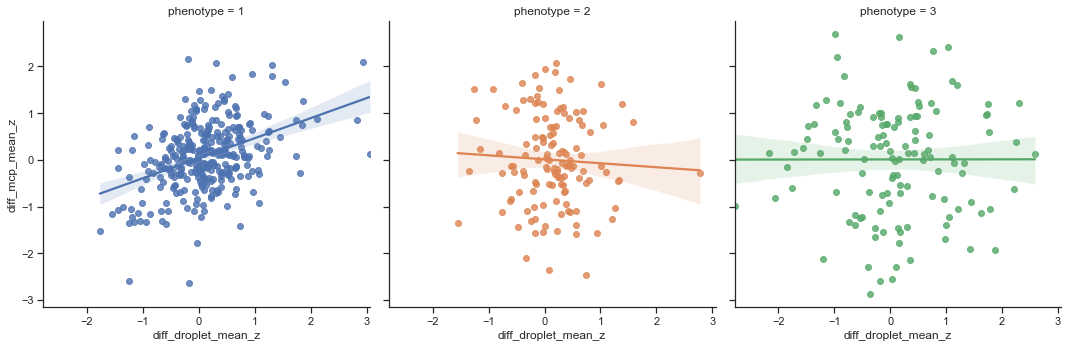

In [31]:
fig = sns.lmplot(
    data=df3,
    x="diff_droplet_mean_z", y="diff_mcp_mean_z",
    col="phenotype", hue="phenotype"
)

- Plot correlation coefficient distribution groupped by ROI phenotypes

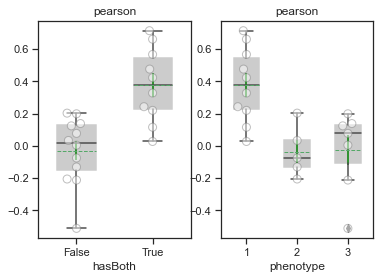

In [32]:
diff_pairwise_corr_fig, diff_pwc = plot_pairwise_corr(
    df3, ["diff_droplet_mean","diff_mcp_mean"],
    method="pearson"
)

diff_pairwise_corr_fig.savefig(
    report_dir.joinpath("diffCorr_boxplot.svg"),
    dpi=300)

In [33]:
diff_pwc.to_csv(str(report_dir.joinpath("diffCorr.csv")))

- Perform Welch t-test (two-sample t-test with unequal sample size and 
unequal variance).

In [34]:
df = (diff_pwc
    .loc[:,["id_","phenotype","hasBoth","pearson"]]
    .drop_duplicates()
)

$H_0: r_\mathrm{ptype1} = r_\mathrm{ptype2}$; $H_1: r_\mathrm{ptype1} > r_\mathrm{ptype2}$

In [35]:
# phenotype
# H_0: r_ptype1 = r_ptype2; H_1: r_ptype1 > r_ptype2
x = df[df["phenotype"]==1]["pearson"]
y = df[df["phenotype"]==2]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 0.0009103231777017362.


$H_0: r_\mathrm{ptype1} = r_\mathrm{ptype3}$; $H_1: r_\mathrm{ptype1} > r_\mathrm{ptype3}$

In [36]:
# H_0: r_ptype1 = r_ptype3; H_1: r_ptype1 > r_ptype3
x = df[df["phenotype"]==1]["pearson"]
y = df[df["phenotype"]==3]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 0.0027632618059250285.


$H_0: r_\mathrm{hasBoth} = r_\mathrm{not-hasBoth}$; $H_1: r_\mathrm{hasBoth} > r_\mathrm{not-hasBoth}$

In [37]:
# hasBoth
# H_0: r_ptype1 = r_ptype2; H_1: r_ptype1 > r_ptype2
x = df[df["hasBoth"]==True]["pearson"]
y = df[df["hasBoth"]==False]["pearson"]
_, p, _ = ttest_ind(x, y, alternative="larger", usevar="unequal")
print(f"P-value is {p}.")

P-value is 0.00020551625933042033.


### Always includ session information

In [38]:
from sinfo import sinfo
sinfo(na=False, dependencies=False, write_req_file=False)

-----
altair              4.1.0
altair_saver        0.5.0
matplotlib          3.3.0
numpy               1.19.1
pandas              1.0.3
seaborn             0.10.1
sinfo               0.3.1
sklearn             0.23.2
statsmodels         0.11.1
-----
IPython             7.17.0
jupyter_client      6.1.6
jupyter_core        4.6.3
notebook            6.1.1
-----
Python 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:37:09) [Clang 10.0.1 ]
Darwin-19.4.0-x86_64-i386-64bit
4 logical CPU cores, i386
-----
Session information updated at 2020-08-11 11:22
